# Sparkify Project Workspace

### Author by: Bao Khanh Nguyen

## Table of Contents



## Introduction

For this project, I will apply my Data Engineering skill to load, transform and process a music app dataset named Spark, which is quite similar with Spotify for predicting churn. If we can predict and identify customers before they churn or then they cancel their service altogether, the business could provide promotion packages like discounts and incentives to prevent customers leave their services, and could save the businesses a lot of money. <br>

This project cointains only a small subset (128 MB) of the full dataset available (12 GB)

Let's we import the necessary libraries, and get our hand dirty


In [1]:
# Import necessary libraries, and spark packages

# Spark Sessions
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
# Spark functions, and types
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *
# for ML models and pipeline
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Import package for datetime transformation
import datetime
import time
# Import necessary packages 
import pandas as pd
import numpy as np
# Import to regex process
import re
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



Spark Session Creation

In [2]:
# Create Spark Session
spark = SparkSession.builder.appName("Bao Pipeline") .getOrCreate()
# Check configuration
spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1670413250873'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.name', 'Bao Pipeline'),
 ('spark.driver.host', '48959a3bb2ba'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '35265'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, we will process our mini-dataset file `mini_sparkify_event_data.json`. We will step by step load, clean and check for invalid or missing in this dataset. For example, a records without userids or sessionides could be identified as invalid 


In [3]:
# Import the the dataset
df = spark.read.json("mini_sparkify_event_data.json")
# Check the dataset first
print(df.describe())

# Do the count of our dataset

print("The original dataset before any cleaning and transform actions:", df.count())
# Check their schema
df.printSchema()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]
The original dataset before any cleaning and transform actions: 286500
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (n

Looking through the dataset, schema and the data types, we do not detect any unsual or abnormval at this stage. We will then process next stage, handle missing and invalid value in this dataset

### Deal with Missing/ Invalid Values

Any missing/invalid values such as missing the userids or sessionides will be dropped.

In [4]:
# userid and/or sessionid if missing will then be dropped
df = df.dropna(subset = ["sessionId", "userId"], how = 'any')

# Check again the dataset 
print("The  dataset after the drop:", df.count())


The  dataset after the drop: 286500


Hmmm... The dataset still the same between the drop. Let's take further more action, and review it again

In [5]:
# Let's drop duplicates these ids, and sort by their values
df.select(["sessionId","userId"] ).dropDuplicates().sort(["sessionId","userId"]).show()


+---------+------+
|sessionId|userId|
+---------+------+
|        1|      |
|        1|100001|
|        1|     2|
|        1|300001|
|        2|200002|
|        3|      |
|        3|100003|
|        3|300003|
|        4|100004|
|        5|      |
|        5|100005|
|        5|     6|
|        6|      |
|        6|100006|
|        6|300006|
|        7|200007|
|        8|      |
|        8|     9|
|        9|      |
|        9|    10|
+---------+------+
only showing top 20 rows



SessionID column are okay right now, but the userID have an empty string, which should be removed before we conduct EDA. Let's drop these emtry string out of our dataset from userID

In [6]:
# Apply Filteration to remove emptry string to remove it
df = df.filter(df["userId"] != "")
# Check the result and the number of records in our mini-dataset again
print(df.select("userId").show())
print(df.count())

+------+
|userId|
+------+
|    30|
|     9|
|    30|
|     9|
|    30|
|     9|
|     9|
|    30|
|    30|
|    30|
|     9|
|     9|
|    30|
|     9|
|     9|
|    30|
|     9|
|    74|
|    30|
|     9|
+------+
only showing top 20 rows

None
278154


After remove empty string from the userID, we are now only have **8346 rows** left. 

Let's convert to Pandas to condcut EDA with our pandas package for easier manipulation


In [7]:
df_pandas = df.toPandas()
df_pandas.head(n=20)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# Exploratory Data Analysis



### Define Churn

We will create a column called `Churn` to reserve as the label for our model. Churn is defined by 'Cancellation Confirmation' events, which occur for both paid and free users. We will assign `1` if a user has churned and a `0` if they have not.

### Explore Data
Exploratory data analysis will be conducted to monitor the behavior of users who are stayed versus users who are churned. 
Firstly, we will explore the how much of a specific action they experienced per a certain time unit or number of songs played between these two groups of users


### Find Users who have churned
First, using  `Cancellation Confirmation` to identify and flag these users who have churned under the `page` column.

In [8]:
# Select `Page` to find about the Cancellation Confirmation information
# This will show all even the duplicate
#df.select("page").show()
# This only show the unique value not the duplicate
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In this page, the need to filter out the "Cancellation Confirmation". Let's add into our filteration in this page with the groupby on UserId and Page to filter out to summarize how many number of this event in our dataset

In [9]:
# show 
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").show()

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
|    87|Cancellation Conf...|
|   122|Cancellation Conf...|
|    12|Cancellation Conf...|
|    58|Cancellation Conf...|
|    73|Cancellation Conf...|
|     3|Cancellation Conf...|
|   106|Cancellation Conf...|
|   103|Cancellation Conf...|
|    28|Cancellation Conf...|
|    54|Cancellation Conf...|
+------+--------------------+
only showing top 20 rows



In [10]:
# number of users who churned
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

With 52 records equal as 52 users in our dataset have did the churn. For the next step, we will flag these users that have churned. For the flagging, we will assign value 1 if churned, and 0 if not. After that, a name column to inform this flag will be named as "Churn_Check"

In [11]:
# Let's wrap the function with udf for reusable function and apply lambda to do multiple values in the dataset
## Check this page for further informationa bout udf function in pyspark
### https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/
# Flage the value =1 if Page has Cancellation Confirmation, and value =0 if page does not have 
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [12]:
# Create new column for our churn event, with our defined function `flag_churn_event`
df = df.withColumn("churn", flag_churn_event("page"))
# Check the result
df.select("churn").dropDuplicates().show()

+-----+
|churn|
+-----+
|    1|
|    0|
+-----+



The churn column was successfully added to the df. 0 and 1 have been assigned to specific userId. Let's sort our userId's value in reverse time order and the total of the churn values.

In [13]:
# sort records for a userIds in reverse time order
## For this sorting, check the article from stackoverflow for the solution with pyspark
### https://stackoverflow.com/questions/35247168/spark-sql-row-number-partitionby-sort-desc
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

# create column churn, which is cucumulative sum per group by "churn" group using in pyspark
## Check this article for solution 
### https://stackoverflow.com/questions/45946349/python-spark-cumulative-sum-by-group-using-dataframe
df = df.withColumn("churn", Fsum("churn").over(windowval))

# groupby churn, and we can correctly get the count 

churn_df = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()

# Check the result
churn_df.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



We have successfully created new column "count", which used to count the total of 0 and 1 in churn columns grouped by "churn" column. We can process to the EDA next part. 

### Exploratory Data Analysis for our Users between Stay and Churned

Before building our models, we need to seperate into two parts:
Numerical and Categorical, and we need to find which aspects impact the decision of stay or churns for our users.

There are few things I could think of like:

- Categorical:
    - Gender 
    - Membership (Free versus Paid)
- Numerical: 
    - Song Impacts:
        - number of songs per session
        - number of songs added to playlist
    - Like/Dislike Action
        - number of thumb down actions 
        - number of thumb up actions
    - Friend
        - number of friends added 
    - Artists Influence:
        - number of different artists listened to on Sparkify 
    - Retention:
        - number of days since registering 



Firstly, Let's do the Numerical first
Let's visualize for easier to see the big picture about the behavior of our users, who did the churn and who decide to stay with the business'service. 

In [14]:
# check our result 
#df_churn.show()
### https://stackoverflow.com/questions/58188072/from-spark-dataframe-to-pandas-dataframe
### Do not use .show() otherwise the conversion will cause errors
churn_df = churn_df.toPandas()

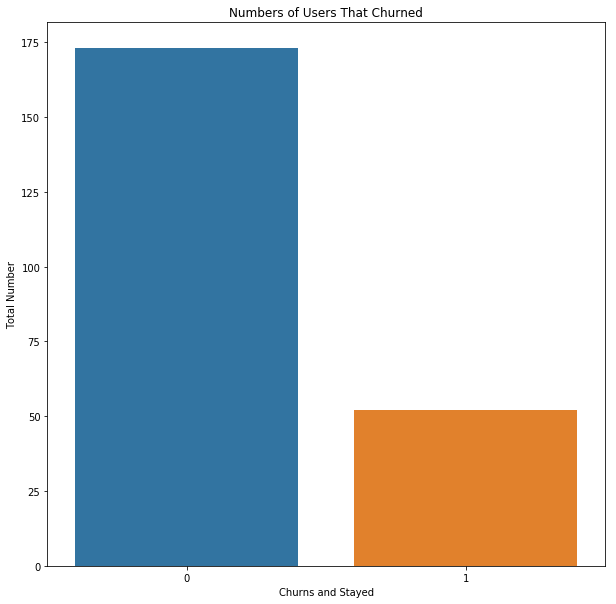

In [15]:
# Visualisation with our Matplotlib package
# Visualization with seaborn barplot to compare
plt.figure(figsize = [10,10])
ax = sns.barplot(data = churn_df, x = 'churn', y='count')
plt.title("Numbers of Users That Churned")
plt.xlabel("Churns and Stayed");
plt.ylabel("Total Number");
plt.show()

In [16]:
rate_df = 52/(173+52) * 100
print("The churn rate is:", rate_df)

The churn rate is: 23.11111111111111


From the figure above, we can cleary see that there are 173 users decided to stay with our business compared to 52 decided to do the churn with the rate of 23% of our users churned. 



### Pages Visited by Those that Churned vs. Those That Stayed

From the Page category, there are differen categories, which users probably perform before making their churn or stay decision. Let's do the comparision


In [17]:
# Import the dataset, groupby Page and churn with the count to count their frequency 
page_df = df.select(['userId', 'churn', 'page']).groupBy('page','churn').count().sort(["churn","count"], ascending = False)
# Check the result
page_df.show(10)

+---------------+-----+-----+
|           page|churn|count|
+---------------+-----+-----+
|       NextSong|    1|36394|
|      Thumbs Up|    1| 1859|
|           Home|    1| 1672|
|Add to Playlist|    1| 1038|
|    Roll Advert|    1|  967|
|     Add Friend|    1|  636|
|         Logout|    1|  553|
|    Thumbs Down|    1|  496|
|      Downgrade|    1|  337|
|       Settings|    1|  270|
+---------------+-----+-----+
only showing top 10 rows



In [18]:
# convert to pandas
page_pd = page_df.toPandas()
# Let's split out users who churned and those who stayed in seperate df
churn_df_count =  page_pd[page_pd['churn'] == 1].sum() 
stay_df_count =  page_pd[page_pd['churn'] == 0].sum()
# Calculate the rate of pages, these people visited before making churn or stay decisions
# Use the total count / each seperate count 
page_pd['rate'] = np.where(page_pd['churn'] == 0, page_pd['count']/stay_df_count['count'], 
                  np.where(page_pd['churn'] == 1, page_pd['count']/churn_df_count['count'],
                page_pd['count']/page_pd['count'])) 

# Check the Result

page_df.head(20)

[Row(page='NextSong', churn=1, count=36394),
 Row(page='Thumbs Up', churn=1, count=1859),
 Row(page='Home', churn=1, count=1672),
 Row(page='Add to Playlist', churn=1, count=1038),
 Row(page='Roll Advert', churn=1, count=967),
 Row(page='Add Friend', churn=1, count=636),
 Row(page='Logout', churn=1, count=553),
 Row(page='Thumbs Down', churn=1, count=496),
 Row(page='Downgrade', churn=1, count=337),
 Row(page='Settings', churn=1, count=270),
 Row(page='Help', churn=1, count=239),
 Row(page='Upgrade', churn=1, count=112),
 Row(page='Save Settings', churn=1, count=58),
 Row(page='About', churn=1, count=56),
 Row(page='Cancel', churn=1, count=52),
 Row(page='Cancellation Confirmation', churn=1, count=52),
 Row(page='Error', churn=1, count=32),
 Row(page='Submit Upgrade', churn=1, count=32),
 Row(page='Submit Downgrade', churn=1, count=9),
 Row(page='NextSong', churn=0, count=191714)]

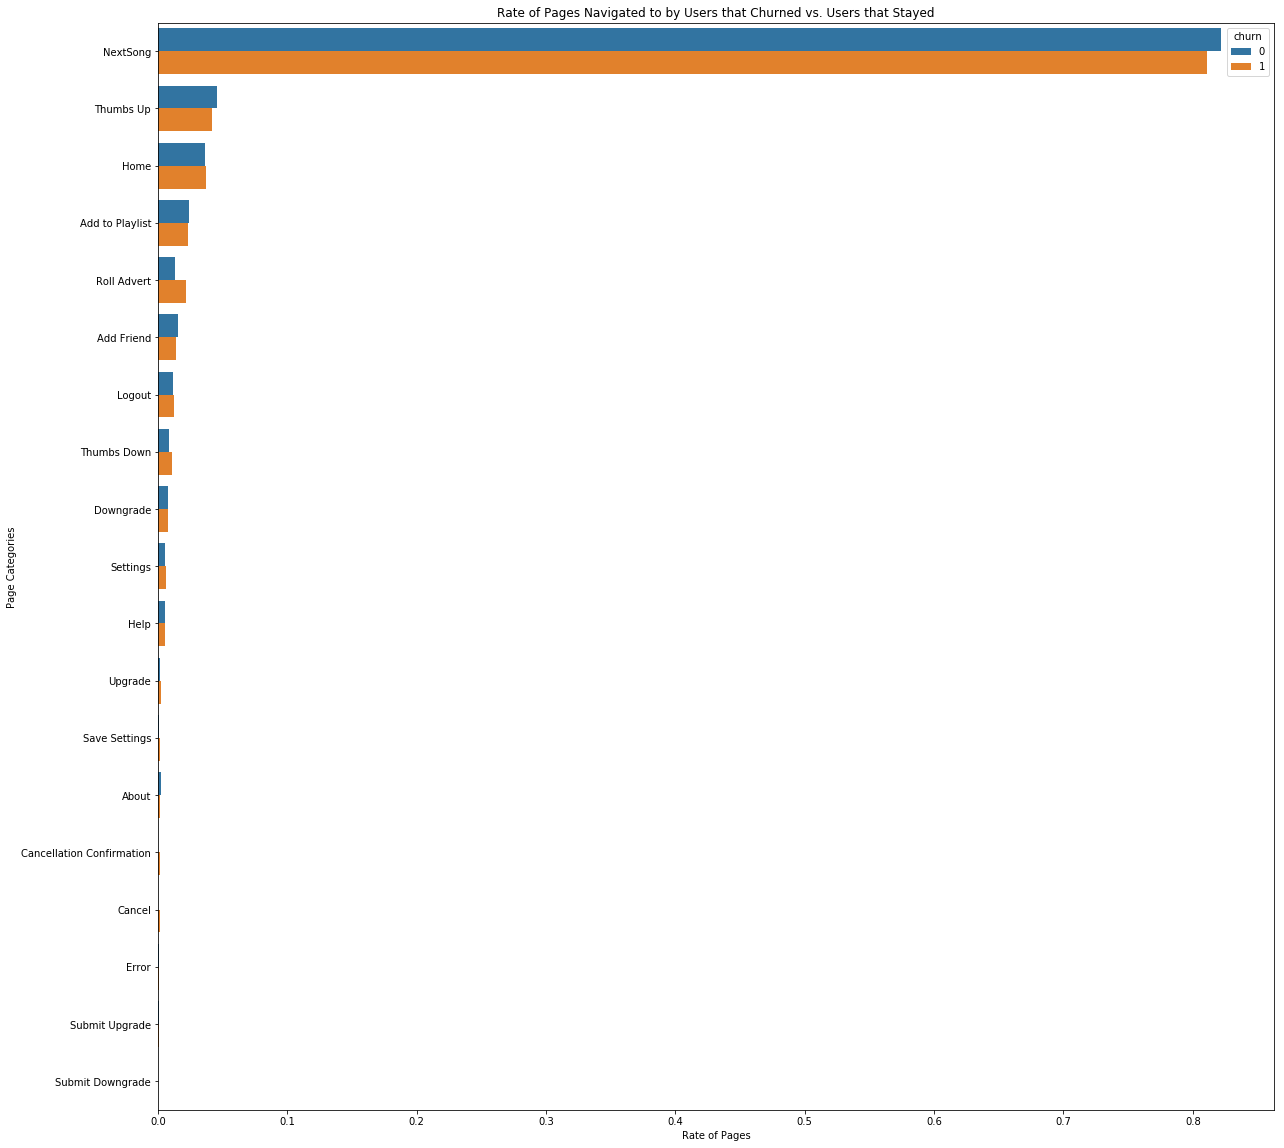

In [19]:
# plot the pages by churn
plt.figure(figsize=[20,20])
sns.barplot(data = page_pd, x = 'rate', y = 'page', hue = 'churn')
plt.title('Rate of Pages Navigated to by Users that Churned vs. Users that Stayed');
plt.xlabel('Rate of Pages');
plt.ylabel ("Page Categories")
plt.show()

According to the above chart, the most popular action for both users who stayed and those who left was to skip to the next song. We can also see that churned users are more likely to roll the ad and thumbs down songs. Those who were more likely to stay did more thumbs up, added friends, and added songs to their playlist.

Songs seem is one of the reasons users decide to stay or churn. Let's break down this category to find down more about song impact. How many hours do users listen between users decide to churn and users decide to stay. 

### Songs Per Hour

Let's calculate the number of songs listened to per hour by both churn and non-churn users.

In [20]:
# Transform timestamp and get the hour after conversion
## Create a function to re-usable with pyspark
hour_df = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

# create column named "hour"
df = df.withColumn("hour", hour_df(df.ts))
# Check result 
df.head(5)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='18'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Darianna', gender='F', itemInSession=33, lastName='Carpenter', length=185.25995, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=187, song='22', status=200, ts=1542823951000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='18'),
 Row(artist='Jo

Let's compare the difference between these churn and non-churn users and their relationship with the hours of song have been played

In [21]:
# create a df with those who didnt churn and which counts when user goes to next song page
hour_stay_song_df = df.filter((df.page == "NextSong") & (df.churn == 0)).groupby(df.hour).count().orderBy(df.hour.cast("float"))


# dataframe with customers who churned and count next song page 
hour_churned_song_df = df.filter((df.page == "NextSong") & (df.churn == 1)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [22]:
# Check the result
#Churn users
print(hour_churned_song_df.show())
#Non-churn users
print(hour_stay_song_df.show())

+----+-----+
|hour|count|
+----+-----+
|   0| 1535|
|   1| 1353|
|   2| 1322|
|   3| 1292|
|   4| 1233|
|   5| 1218|
|   6| 1218|
|   7| 1218|
|   8| 1230|
|   9| 1230|
|  10| 1380|
|  11| 1390|
|  12| 1408|
|  13| 1571|
|  14| 1702|
|  15| 1892|
|  16| 1915|
|  17| 1996|
|  18| 1978|
|  19| 1818|
+----+-----+
only showing top 20 rows

None
+----+-----+
|hour|count|
+----+-----+
|   0| 7527|
|   1| 7035|
|   2| 7014|
|   3| 7063|
|   4| 6914|
|   5| 6960|
|   6| 6836|
|   7| 6873|
|   8| 7023|
|   9| 7268|
|  10| 7502|
|  11| 7440|
|  12| 7918|
|  13| 8073|
|  14| 8792|
|  15| 9462|
|  16| 9721|
|  17| 9464|
|  18| 9146|
|  19| 9112|
+----+-----+
only showing top 20 rows

None


In [23]:
# convert to pandas, and to numeric for visualization
#non-churn users
hour_stay_song_pd = hour_stay_song_df.toPandas()
hour_stay_song_pd.hour = pd.to_numeric(hour_stay_song_pd.hour)

# Churn-users
hour_churned_song_pd = hour_churned_song_df.toPandas()
hour_churned_song_pd.hour = pd.to_numeric(hour_churned_song_pd.hour)

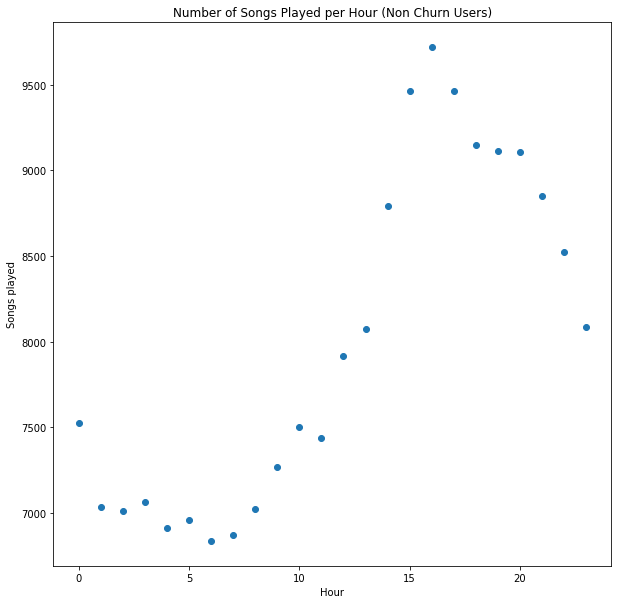

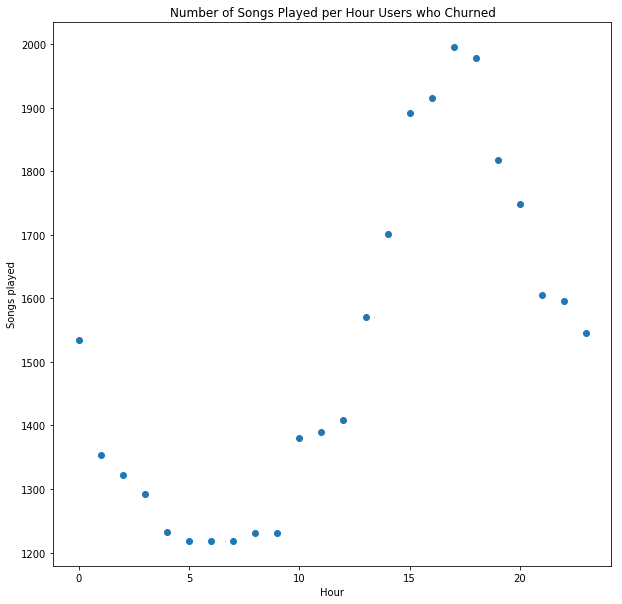

In [24]:
# Visualization for non-churn users
# Use scatter plot to see the relationship
plt.figure(figsize = [10,10])
plt.scatter(hour_stay_song_pd["hour"], hour_stay_song_pd["count"])
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour (Non Churn Users)")
plt.show();


#Visualization for churn user
# use scatter plot to see the relationship
plt.figure(figsize = [10,10])
plt.scatter(hour_churned_song_pd["hour"], hour_churned_song_pd["count"])
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour Users who Churned")
plt.show();

From these figures above, we can see that both churned-users and non-churned users have the similar pattern distribution. Around **3pm** experienced the peak of songs have been played between these two types of users, and it started to fall down rapidly since 3pm. However, **3pm-8pm** is the golden time for both two types of users because they likely to listen to songs more compared to other time during a day.

However, the frequency of played songs tend for churned users are fewer around **2000** compared to **9500** for non-churned users. 

### Song per Sessions between Churned and Non-churned users

We could make a predict that the churned users tend to have fewer listen session compared to non-churned users. However, Let's do a quick check to ensure we are correct

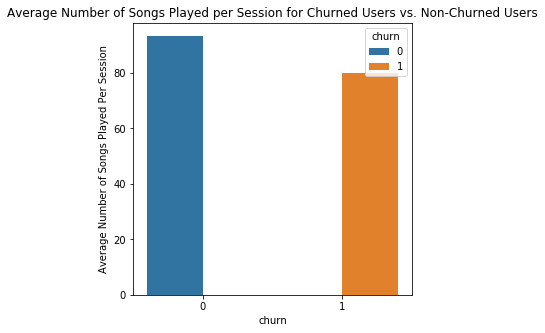

In [25]:
# Filter page with "NextSong", get the unique category, and do the group by their session id and churn we have built above
song_df= df.filter(df.page == "NextSong").dropDuplicates().groupBy('sessionId','churn').count()

# get average grouped by churn

avg_song_df = song_df.groupby('churn').agg({"count":"avg"})

# to Pandas for plotting
avg_song_pd = avg_song_df.toPandas()

# visualization with barplot to check 
plt.figure(figsize = [5,5])
ax = sns.barplot(data = avg_song_pd, x = 'churn', y='avg(count)', hue = "churn")
plt.title("Average Number of Songs Played per Session for Churned Users vs. Non-Churned Users")
plt.ylabel("Average Number of Songs Played Per Session")
plt.show();

From the figure above, the result is like our expected that the churned users tend to listen to fewer songs per sessions compared to non-churned users. 

### Number of different artists listen by churned and non-churned users

In [26]:
# Filter the artists, and groupby users id and churn
artist_df = df.select("artist", "userId", "churn").dropDuplicates().groupby("userId", "churn").count()
#to pandas
artist_pd = artist_df.toPandas()


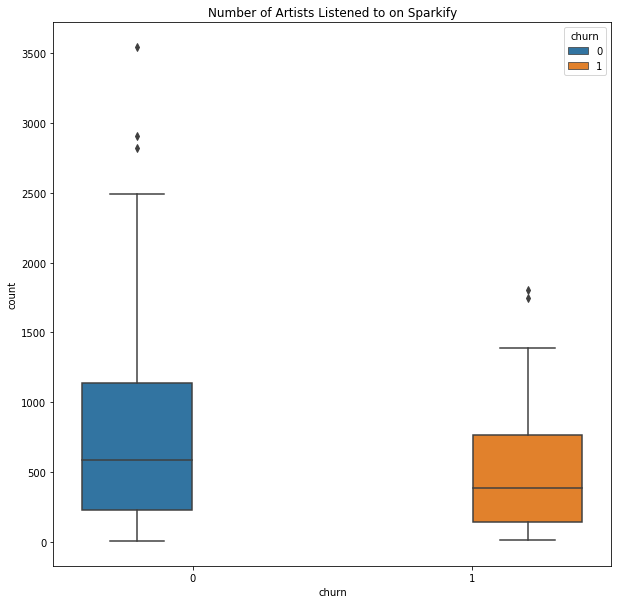

In [27]:
# Visualiation
#plot boxplot
plt.figure(figsize = [10,10 ])
ax = sns.boxplot(data = artist_pd, x = 'churn', y='count', hue='churn')
plt.title("Number of Artists Listened to on Sparkify")
plt.show();

From the boxplot, we can see that non-churned users tend to listen different number of artists compared to churned users around 200 difference between these two types of users.

#### Number of songs added to playlist 

In [28]:
# Create function to flag

add_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
#Assign value into this new df
playlist_df = df.select(["userId", "page"])
# Create new column Playlist
playlist_df = df.withColumn("Playlist", add_playlist("page"))

# Check the result
playlist_df=playlist_df.filter(playlist_df.page == "Add to Playlist").groupBy(['churn', 'Playlist']).count()
playlist_df.show()

+-----+--------+-----+
|churn|Playlist|count|
+-----+--------+-----+
|    1|       1| 1038|
|    0|       1| 5488|
+-----+--------+-----+



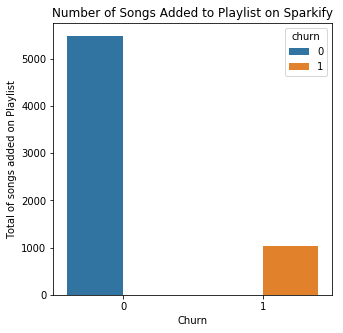

In [29]:
#to pandas for thumb down
playlist_df_pd = playlist_df.toPandas()

# Visualiaton
## Visualiation for add playlist
#plot barplot
plt.figure(figsize = [5,5 ])
ax = sns.barplot(data = playlist_df_pd, x = 'churn', y='count', hue='churn')
plt.title("Number of Songs Added to Playlist on Sparkify")
plt.xlabel("Churn")
plt.ylabel("Total of songs added on Playlist")
plt.show();

From the above figure, we could see that non-churned users tend to add more songs into their playlists compared to users decided to churn, more than 5000 songs compare to 1000 songs respectively. 



### Friend
   #### Number of friends added 

In [30]:
# Create function to flag

add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())#Assign value into this new df
friend_df = df.select(["userId", "page"])
# Create new column Add Friend
friend_df = df.withColumn("Add_Friend", add_friend("page"))

# Check the result
friend_df=friend_df.filter(friend_df.page == "Add Friend").groupBy(['churn', 'Add_Friend']).count()
friend_df.show()

+-----+----------+-----+
|churn|Add_Friend|count|
+-----+----------+-----+
|    1|         1|  636|
|    0|         1| 3641|
+-----+----------+-----+



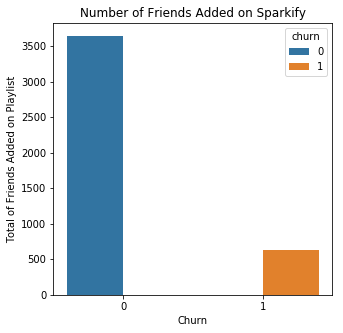

In [31]:
#to pandas
friend_df_pd = friend_df.toPandas()

# Visualiaton
#plot barplot
plt.figure(figsize = [5,5 ])
ax = sns.barplot(data = friend_df_pd , x = 'churn', y='count', hue='churn')
plt.title("Number of Friends Added on Sparkify")
plt.xlabel("Churn")
plt.ylabel("Total of Friends Added on Playlist")
plt.show();

Like the number of songs added on Sparkify, the number of friends added for non-churned users are higher more than 3500 friends compared to only under 1000 friends for users decided to churn

### Retention:
#### Number of days since registering 


In [32]:
# create new dataframe, and choose registration to check with ts for datetime
## Remember to use sort to sort by their dates
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')

# order by lastest date
# I use this page to create Rank with dense rank to rank the date with windown function
#https://sparkbyexamples.com/pyspark/pyspark-window-functions/
# window function for sorting with pyspark
w = Window.partitionBy("userId").orderBy(desc("ts"))
# create a rank with the most recent timestamp as rank number 1
df_days = df_days.withColumn("Rank", dense_rank().over(w))
# Check the result
df_days.show()

+------+-------------+-------------+-----+----+
|userId| registration|           ts|churn|Rank|
+------+-------------+-------------+-----+----+
|    10|1538159495000|1542631788000|    0|   1|
|    10|1538159495000|1542631753000|    0|   2|
|    10|1538159495000|1542631690000|    0|   3|
|    10|1538159495000|1542631518000|    0|   4|
|    10|1538159495000|1542631517000|    0|   5|
|    10|1538159495000|1542631090000|    0|   6|
|    10|1538159495000|1542630866000|    0|   7|
|    10|1538159495000|1542630637000|    0|   8|
|    10|1538159495000|1542630407000|    0|   9|
|    10|1538159495000|1542630394000|    0|  10|
|    10|1538159495000|1542630248000|    0|  11|
|    10|1538159495000|1542630247000|    0|  12|
|    10|1538159495000|1542630029000|    0|  13|
|    10|1538159495000|1542629861000|    0|  14|
|    10|1538159495000|1542629636000|    0|  15|
|    10|1538159495000|1542629464000|    0|  16|
|    10|1538159495000|1542629238000|    0|  17|
|    10|1538159495000|1542629029000|    

In [33]:
# Get rank 1for first row 
df_days = df_days.filter(df_days.Rank == 1).drop(df_days.Rank)

# Createn new column name delta to find the difference between the registration from ts 
df_days = df_days.withColumn("delta", (df_days['ts']) - (df_days['registration']))
# Convert to days 
df_days = df_days.withColumn('days',(df_days['delta']/1000/3600/24))

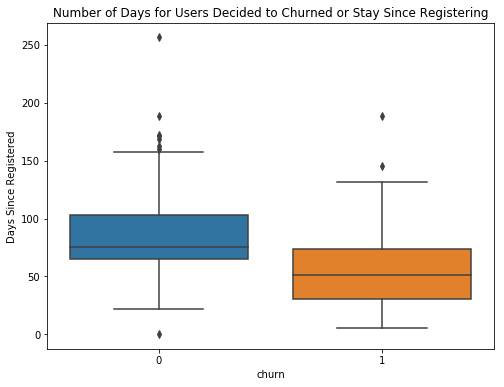

In [34]:
# to Pandas 
df_days_pd = df_days.toPandas()
# plot boxplot
plt.figure(figsize=[8,6])
sns.boxplot(data = df_days_pd, x = 'churn', y ='days')
plt.ylabel("Days Since Registered")
plt.title('Number of Days for Users Decided to Churned or Stay Since Registering')
plt.show();

Those who had been registered with Sparkify for a longer period of time were more likely to stay. Users who had recently registered were more likely to churn.

### Like/Dislike Action
#### Number of thumb down actions 

In [35]:
# Thumbdown 
thumbdown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
thumbdown_df = df.withColumn("Thumbs Down", thumbdown_event("page"))

#thumb up
thumbup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
thumbup_df = df.withColumn("Thumbs Up", thumbup_event("page"))

# Check the result
# Thumbdown
thumb_down_df= thumbdown_df.filter(thumbdown_df.page == "Thumbs Down").dropDuplicates().groupBy(['churn', 'Thumbs Down']).count()
thumb_down_df.show()

#ThumbUp
thumbup_df= thumbup_df.filter(thumbup_df.page == "Thumbs Up").dropDuplicates().groupBy(['churn', 'Thumbs Up']).count()
thumbup_df.show()


+-----+-----------+-----+
|churn|Thumbs Down|count|
+-----+-----------+-----+
|    1|          1|  496|
|    0|          1| 2050|
+-----+-----------+-----+

+-----+---------+-----+
|churn|Thumbs Up|count|
+-----+---------+-----+
|    1|        1| 1859|
|    0|        1|10692|
+-----+---------+-----+



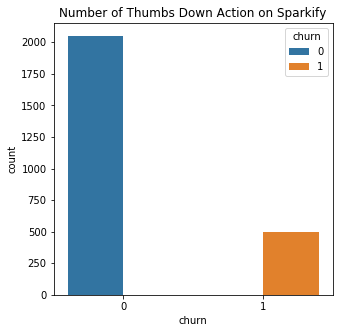

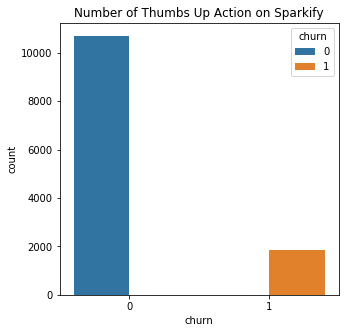

In [36]:
#to pandas for thumb down
thumb_down_pd = thumb_down_df.toPandas()
#to pandas for thumb up
thumbup_pd = thumbup_df.toPandas()

# Visualiaton
## Visualiation for Thumb Downs
#plot barplot
plt.figure(figsize = [5,5 ])
ax = sns.barplot(data = thumb_down_pd, x = 'churn', y='count', hue='churn')
plt.title("Number of Thumbs Down Action on Sparkify")
plt.show();

## Visualiation for Thumbs Up
#plot barplot
plt.figure(figsize = [5,5 ])
ax = sns.barplot(data = thumbup_pd, x = 'churn', y='count', hue='churn')
plt.title("Number of Thumbs Up Action on Sparkify")
plt.show();


From above figures, we could cleary see that the thumb up or thumb down actions of non-churned users are higher compared to churned users. Users tend to stay spend more like/dislike actions compared to users who decide to churn

###  Categorical Membership:
#### Users who churned and non-churned users by their membership type

In [37]:
# create the level dataframe. level meaning here is their membership type
df_member = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count()
# Check the result
df_member.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



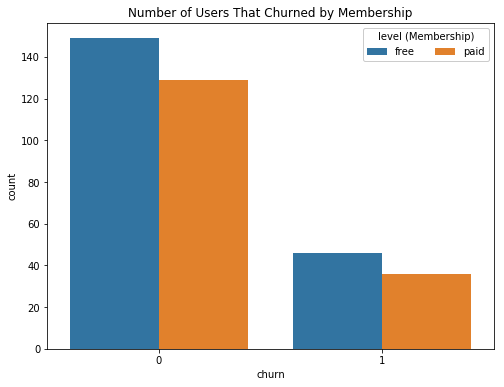

In [38]:
# convert to pandas for visualisation
member_pd= df_member.toPandas()

# plot the barplot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = member_pd, x = 'churn', y='count', hue = 'level')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'level (Membership)')
plt.title("Number of Users That Churned by Membership");

In [39]:
# free churn rate
print(46/(46+149))

# paid churn rate
print(36/(129+36))

0.2358974358974359
0.21818181818181817


From above figures, we can see that free user likely to churn with 23.6% rate compared to paid users with the rate only 21.8%. 

Now, moving into discover about could "gender" impact on the churn or stay decision. 



###  Categorical Gender: Impact on Users who Churned vs Users who Stayed

In [40]:
# create gender df grouped by userID, churn and gender by order
df_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()
#Check the result
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



In [41]:
# Convert into Pandas and do the visualization
df_gender = df_gender.toPandas()

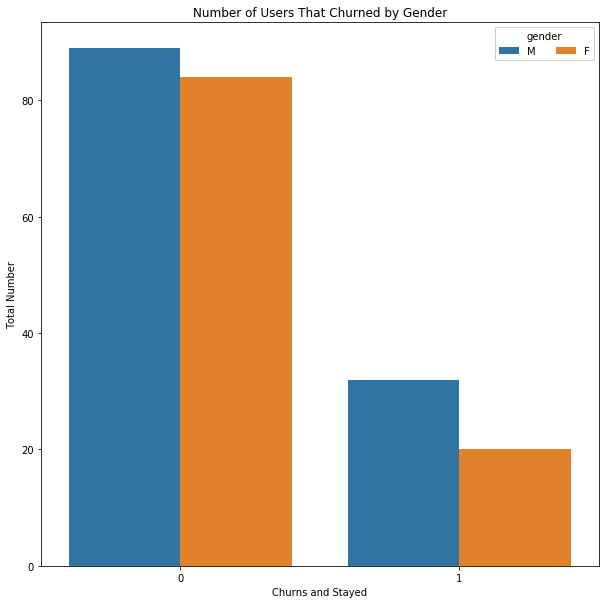

In [42]:
# order for the visualisation
df_gender = df_gender.sort_values('count', ascending = False)


# seaborn barplot
plt.figure(figsize = [10,10])
ax = sns.barplot(data = df_gender, x = 'churn', y='count', hue = 'gender')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'gender')
plt.title("Number of Users That Churned by Gender");
plt.xlabel("Churns and Stayed");
plt.ylabel("Total Number");
plt.show()

In [43]:
# Calculate the churn rate between females and males
# female churn rate
female_churn= 20/(20+84)
# male churn rate
male_churn=32/(89+32)

print("Churn Rate for Female Users:", female_churn)
print("Churn Rate for Male Users:",male_churn)

Churn Rate for Female Users: 0.19230769230769232
Churn Rate for Male Users: 0.2644628099173554


Male have higher churn rate compared to Female Users, 0.264 compared to 0192 respectively. However, it is not a big difference between male and female users. 

# Feature Engineering

After we have some insights of our data, we can finally build these features that could be used for our model later on. 


The features for trainning models:

- Categorical:
    - Gender 
    - Membership (Free versus Paid)
- Numerical: 
    - Song Impacts:
        - number of songs per session
        - number of songs added to playlist
    - Like/Dislike Action
        - number of thumb down actions 
        - number of thumb up actions
    - Friend
        - number of friends added 
    - Artists Influence:
        - number of different artists listened to on Sparkify 
    - Retention:
        - number of days since registering 
 
We'll then add a `churn label` and combine everything together. This will generate a df with each row representing information about a single user. After we remove the `userId`, we can vectorize, standardize, and feed this df into our different machine learning algorithms.

First we will take our `categorical variables:` Gender and Membership for numeric conversion for our model.

### Gender
We'll give a 1 for 'female' and a 0 for'male.'

In [44]:
# create new df
gender_new = df.select(['userId', 'gender']).dropDuplicates()

# create gender column 
gender_new = gender_new.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

In [45]:
# check the result
gender_new.count()

225

In [46]:
# check again
gender_new.show()

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   116|     1|
|200001|     0|
|200020|     0|
|100008|     1|
|200015|     0|
|   100|     0|
|100006|     1|
|300005|     1|
|    25|     1|
+------+------+
only showing top 20 rows



### Membership 
The next feature we'll look at is Membership or Level in our dataset. Because the level could change, we must only use the most recent. We can use the previous rank trick, which have been used for rank number of days since registeration.

In [47]:
# Select 
membership_new = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

# Window function with dense_Rank function
#https://sparkbyexamples.com/pyspark/pyspark-window-functions/
w = Window.partitionBy("userId").orderBy(desc("ts"))
membership_new = membership_new.withColumn("Rank", dense_rank().over(w))
# Check the result
membership_new.show()

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
|    10| paid|1542630248000|  11|
|    10| paid|1542630247000|  12|
|    10| paid|1542630029000|  13|
|    10| paid|1542629861000|  14|
|    10| paid|1542629636000|  15|
|    10| paid|1542629464000|  16|
|    10| paid|1542629238000|  17|
|    10| paid|1542629029000|  18|
|    10| paid|1542629028000|  19|
|    10| paid|1542628798000|  20|
+------+-----+-------------+----+
only showing top 20 rows



In [48]:
# Choose Rank = 1 only and drop the others
membership_v2= membership_new.filter(membership_new.Rank == 1).drop('Rank')
# and drop ts
membership_v2 = membership_v2.drop('ts')
# Add new column name
membership_v2 = membership_v2.withColumn('membership', when(col('level') == 'paid', 1).otherwise(0))

In [49]:
# Do the count
print(membership_v2.count())
# Check the result
print(membership_v2.show())

225
+------+-----+----------+
|userId|level|membership|
+------+-----+----------+
|    10| paid|         1|
|   100| paid|         1|
|100001| free|         0|
|100002| paid|         1|
|100003| free|         0|
|100004| paid|         1|
|100005| free|         0|
|100006| free|         0|
|100007| paid|         1|
|100008| free|         0|
|100009| free|         0|
|100010| free|         0|
|100011| free|         0|
|100012| free|         0|
|100013| paid|         1|
|100014| paid|         1|
|100015| paid|         1|
|100016| free|         0|
|100017| free|         0|
|100018| free|         0|
+------+-----+----------+
only showing top 20 rows

None


#### Average number of songs played per session

In [50]:
## Choose
song_new = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()
# Group for average calcualtion
song_new = song_new.groupby('userId').agg({"count":"avg"})
# Create new column avg for count
song_new = song_new.withColumnRenamed("avg(count)", "Average Songs")

In [51]:
# Check 
print(song_new.count())
print(song_new.show())

225
+------+------------------+
|userId|     Average Songs|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows

None


#### Number of like and dislike actions

In [52]:
# Thumb down first
thumbdown_new = df.select(["userId", "page"])
# Thumb up second
thumbup_new = df.select(["userId", "page"])
# This function we have code above, just re-call it again no need to run
#thumddown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
#thumbup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())

## add new columns 
# Down
thumbdown_new = thumbdown_new.withColumn("Thumbs Down", thumbdown_event("page"))
# Up
thumbup_new = thumbup_new.withColumn("Thumbs Up", thumbup_event("page"))

# Do the sum
# Down 
thumbdown_new = thumbdown_new.groupby('userId').sum("Thumbs Down")
# Up
thumbup_new = thumbup_new.groupby('userId').sum("Thumbs Up")
# Create new column 
thumbdown_new = thumbdown_new.withColumnRenamed("sum(Thumbs Down)", "Total Thumbs Down")
thumbup_new = thumbup_new.withColumnRenamed("sum(Thumbs Up)", "Total Thumbs Up")

In [53]:
# Check the thumb down count and its result
print(thumbdown_new.count())
print(thumbdown_new.show())
# check the thumb up count and its result
print(thumbup_new.count())
print(thumbup_new.show())

225
+------+-----------------+
|userId|Total Thumbs Down|
+------+-----------------+
|100010|                5|
|200002|                6|
|   125|                0|
|    51|               21|
|   124|               41|
|     7|                1|
|    54|               29|
|    15|               14|
|   155|                3|
|   132|               17|
|   154|                0|
|100014|                3|
|   101|               16|
|    11|                9|
|   138|               24|
|300017|               28|
|    29|               22|
|    69|                9|
|100021|                5|
|    42|               25|
+------+-----------------+
only showing top 20 rows

None
225
+------+---------------+
|userId|Total Thumbs Up|
+------+---------------+
|100010|             17|
|200002|             21|
|   125|              0|
|    51|            100|
|   124|            171|
|     7|              7|
|    54|            163|
|    15|             81|
|   155|             58|
|   132|     

#### Number of Friends Added
Similarly, the number of friends added can indicate whether or not a user is likely to churn. Previously, those who added more friends stayed on the app.

In [54]:
# Select
friend_new = df.select(["userId", "page"])
# this function has been code above
#add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
friend_new= friend_new.withColumn("add_friend", add_friend("page"))
friend_new = friend_new.groupby('userId').sum("add_friend")

friend_new = friend_new.withColumnRenamed("sum(add_friend)", "Total Add Friend")

In [55]:
# Check the add friend in this friend_new
print(friend_new.count())
print(friend_new.show())

225
+------+----------------+
|userId|Total Add Friend|
+------+----------------+
|100010|               4|
|200002|               4|
|   125|               0|
|    51|              28|
|   124|              74|
|     7|               1|
|    54|              33|
|    15|              31|
|   155|              11|
|   132|              41|
|   154|               3|
|100014|               6|
|   101|              29|
|    11|               6|
|   138|              41|
|300017|              63|
|    29|              47|
|    69|              12|
|100021|               7|
|    42|              52|
+------+----------------+
only showing top 20 rows

None


### Number of songs added to playlist
Again, those who added more songs to their playlists had stayed with the service so this can provide an indication of whether a user is likely to churn.

In [56]:
# Select
playlist_new= df.select(["userId", "page"])
# this function has been defined above
#add_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
# Create new columns 
playlist_new = playlist_new.withColumn("Playlist", add_playlist("page"))
# do the group and sum
playlist_new = playlist_new.groupby('userId').sum("Playlist")
# create new column for new sum column
playlist_new = playlist_new.withColumnRenamed("sum(Playlist)","Total Playlist")

In [57]:
# Check the number of songs added to playlist
print(playlist_new.count())
print(playlist_new.show())

225
+------+--------------+
|userId|Total Playlist|
+------+--------------+
|100010|             7|
|200002|             8|
|   125|             0|
|    51|            52|
|   124|           118|
|     7|             5|
|    54|            72|
|    15|            59|
|   155|            24|
|   132|            38|
|   154|             1|
|100014|             7|
|   101|            61|
|    11|            20|
|   138|            67|
|300017|           113|
|    29|            89|
|    69|            33|
|100021|             7|
|    42|           104|
+------+--------------+
only showing top 20 rows

None


### Number of different Artists Listened to on Sparkify
Users who listened to more diverse artists were less likely to churn, as we discovered in EDA.

In [58]:
artist_new = df.select("userId", "artist").dropDuplicates().groupby("userId").count()
artist_new = artist_new.withColumnRenamed("count", "Number of Artists")

In [59]:
# Check the count and the results
print(artist_new.count())
print(artist_new.show())

225
+------+-----------------+
|userId|Number of Artists|
+------+-----------------+
|100010|              253|
|200002|              340|
|   125|                9|
|    51|             1386|
|   124|             2233|
|     7|              143|
|    15|             1303|
|    54|             1745|
|   155|              644|
|   132|             1300|
|   154|               79|
|100014|              234|
|   101|             1242|
|    11|              535|
|   138|             1333|
|300017|             2071|
|    29|             1805|
|    69|              866|
|100021|              208|
|    42|             2074|
+------+-----------------+
only showing top 20 rows

None


### Number of Days Since Registering

Our EDA also thought the number of days since registering was useful. We discovered that users who had used the service for a shorter period of time churned more than those who had used it for a longer period of time.

In [60]:

days_new = df_days.drop('registration', 'ts', 'churn', 'delta')

In [61]:
# Check the count and the results
print(days_new.count())
print(days_new.show())


225
+------+------------------+
|userId|              days|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
|100004|172.44008101851853|
|100005| 85.19559027777778|
|100006| 9.127164351851851|
|100007|115.38761574074074|
|100008| 68.22856481481482|
|100009| 37.43827546296296|
|100010|  55.6436574074074|
|100011| 5.165115740740741|
|100012| 43.05261574074074|
|100013| 44.17873842592593|
|100014| 85.08340277777778|
|100015| 67.87921296296297|
|100016| 75.01533564814815|
|100017| 78.88440972222223|
|100018|110.71211805555555|
+------+------------------+
only showing top 20 rows

None


#### Label Creation
Now we can create our `label column`, which will indicate whether the user churned (1) or not.

In [62]:
label = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()

label = label.drop('count')

label = label.withColumnRenamed("churn", "label")

In [63]:
# Check the count and the results
# its should have the same 225
print(label.count())
print(label.show())

225
+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows

None


#### Create Features for our Dataset

Let's join our new features together by `userid`

In [64]:
feature_df = gender_new.join(membership_v2, ["userId"]).join(song_new, ["userId"]).join(thumbdown_new, ["userId"]).join(thumbup_new, ["userId"]).join(friend_new, ["userId"]).join(playlist_new, ["userId"]).join(artist_new, ["userId"]).join(days_new, ["userId"]).join(label, ["userId"])
# After join, we have to drop it
feature_df = feature_df.drop('userId')


In [65]:
feature_df  = feature_df.drop('level')


#### Preprocessing


In [66]:
# print schema
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- membership: integer (nullable = false)
 |-- Average Songs: double (nullable = true)
 |-- Total Thumbs Down: long (nullable = true)
 |-- Total Thumbs Up: long (nullable = true)
 |-- Total Add Friend: long (nullable = true)
 |-- Total Playlist: long (nullable = true)
 |-- Number of Artists: long (nullable = false)
 |-- days: double (nullable = true)
 |-- label: long (nullable = true)



We have to convert all to numerical datatype before we can train our models

In [67]:
# Do the looping to convert all columns 
# Use float datatype for conversion
for feature in feature_df.columns:
    feature_df = feature_df.withColumn(feature, feature_df[feature].cast('float'))
    
    
#check again
feature_df.printSchema()

root
 |-- gender: float (nullable = false)
 |-- membership: float (nullable = false)
 |-- Average Songs: float (nullable = true)
 |-- Total Thumbs Down: float (nullable = true)
 |-- Total Thumbs Up: float (nullable = true)
 |-- Total Add Friend: float (nullable = true)
 |-- Total Playlist: float (nullable = true)
 |-- Number of Artists: float (nullable = false)
 |-- days: float (nullable = true)
 |-- label: float (nullable = true)



In [68]:
# Check the result
#features_df.show(5)

#### Vector Transformation

The vector transformation purpose is to convert our features into `vectors`. The vector can then be `standardised` and fed into the algorithms of our choice.

In [69]:
#Check this article for correct way
#https://medium.com/@nutanbhogendrasharma/feature-transformer-vectorassembler-in-pyspark-ml-feature-part-3-b3c2c3c93ee9
# https://pyshark.com/vectorassembler-in-pyspark/
vector= VectorAssembler(inputCols = ["gender", "membership", "Average Songs", "Total Thumbs Down", "Total Thumbs Up", "Total Add Friend", "Total Playlist", "Number of Artists", "days"], outputCol = "vec")
# Trasnformation
trans_features_df = vector.transform(feature_df)


In [70]:
trans_features_df.show()

+------+----------+-------------+-----------------+---------------+----------------+--------------+-----------------+----------+-----+--------------------+
|gender|membership|Average Songs|Total Thumbs Down|Total Thumbs Up|Total Add Friend|Total Playlist|Number of Artists|      days|label|                 vec|
+------+----------+-------------+-----------------+---------------+----------------+--------------+-----------------+----------+-----+--------------------+
|   1.0|       0.0|    39.285713|              5.0|           17.0|             4.0|           7.0|            253.0| 55.643658|  0.0|[1.0,0.0,39.28571...|
|   0.0|       1.0|         64.5|              6.0|           21.0|             4.0|           8.0|            340.0|  70.07463|  0.0|[0.0,1.0,64.5,6.0...|
|   0.0|       0.0|          8.0|              0.0|            0.0|             0.0|           0.0|              9.0|  71.31689|  1.0|(9,[2,7,8],[8.0,9...|
|   1.0|       1.0|    145.67857|             41.0|          171

### Standardisation

We can standardize our values now that we have our vectors. This is important for our ML models because it prevents the features with the highest values from dominating the results and allows us to make the individual features look like standard normally distributed data.

In [71]:
scaler = StandardScaler(inputCol="vec", outputCol="features", withStd=True)

In [72]:
scaler_model = scaler.fit(trans_features_df)




In [73]:
trans_features_df= scaler_model.transform(trans_features_df)


In [74]:
feature_complete = trans_features_df
# Check the result
feature_complete.head(5)

[Row(gender=1.0, membership=0.0, Average Songs=39.28571319580078, Total Thumbs Down=5.0, Total Thumbs Up=17.0, Total Add Friend=4.0, Total Playlist=7.0, Number of Artists=253.0, days=55.64365768432617, label=0.0, vec=DenseVector([1.0, 0.0, 39.2857, 5.0, 17.0, 4.0, 7.0, 253.0, 55.6437]), features=DenseVector([2.0013, 0.0, 0.9219, 0.3823, 0.2596, 0.1943, 0.214, 0.4189, 1.4775])),
 Row(gender=0.0, membership=1.0, Average Songs=64.5, Total Thumbs Down=6.0, Total Thumbs Up=21.0, Total Add Friend=4.0, Total Playlist=8.0, Number of Artists=340.0, days=70.07463073730469, label=0.0, vec=DenseVector([0.0, 1.0, 64.5, 6.0, 21.0, 4.0, 8.0, 340.0, 70.0746]), features=DenseVector([0.0, 2.0844, 1.5135, 0.4588, 0.3207, 0.1943, 0.2445, 0.563, 1.8606])),
 Row(gender=0.0, membership=0.0, Average Songs=8.0, Total Thumbs Down=0.0, Total Thumbs Up=0.0, Total Add Friend=0.0, Total Playlist=0.0, Number of Artists=9.0, days=71.31688690185547, label=1.0, vec=SparseVector(9, {2: 8.0, 7: 9.0, 8: 71.3169}), feature

### Split for Train and Test Dataset

In [75]:
# Check so see how many records we have in the total 225 values
feature_complete.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



This is as expected; we can now divide our data into train, test, and validation sets. 

Based on this [article](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/). I strongly suggest a 60:20:20 split here and include a seed so we can replicate the result. I used the same seed for each machine learning model so that my results could be replicated.

In [76]:
train, test, valid = feature_complete.randomSplit([0.6, 0.2, 0.2], seed = 1996)
print("Training Dataset:" + str(train.count()))
print("Test Dataset:" + str(test.count()))
print("Validation Dataset:" + str(valid.count()))

Training Dataset:142
Test Dataset:47
Validation Dataset:36


# Modeling

We have now completed our features. We can divide the entire dataset into train, test, and validation sets using a dataFrame with only numeric variables. We will put various machine learning classification algorithms to the test, including:
Logistic Regression -
 - Logistic Regression
 - Random Forest Classifier
 - Gradient-Boosted Tree Classifier
 - Linear Support Vector Machine

We will use these classification algorithms because churn prediction is a binary classification problem, which means that customers will either churn (1) or stay (0) within a given time period.


# Measurement to measure

We will assess the accuracy of the various models and adjust parameters as needed. Finally, based on test accuracy, we will select our best model and report results on the `validation set`. Because churned users are a relatively small subset, I will optimize using the `F1 score`. 

`F1 score` is a model's accuracy on a dataset that is used to evaluate binary classification systems like the one we have here. 

The `F1-score` is a method of combining the model's precision and recall, and it provides a better measure of incorrectly classified cases than the accuracy metric. F1 is also better for dealing with classes that are imbalanced. 

We can now begin modeling. We will tune the model once we have identified the model with the best F1 score, accuracy, and time. The models I chose are listed below, along with the reasons why they were chosen. Each model chosen is appropriate for our binary classification problem of predicting churn.


- **Logistic Regression**: The first machine learning algorithm we can try is logistic regression. Because this is a binary classification problem, logistic regression is a reliable machine learning algorithm to try. Logistic regression provides a model with good explainability. Logistic regression is also simple to implement, interpret, and train. It also has a lower proclivity for overfitting.  

- **Random Forest:** Random Forest is an effective supervised learning algorithm for classification. RF is an ensemble method that predicts using multiple decision trees and uses a majority vote to make decisions. This can aid in avoiding overfitting. RF is also robust and performs well on imbalanced datasets like the one we have here.

- **Gradient Boosted Tree Classifier:** GBT has a high predictive accuracy. In contrast to RF, which builds trees independently, this works by building one tree at a time, with each new tree helping to correct errors made by the previous tree. With GBT, there is a risk of overfitting, which must be considered. GBT, on the other hand, performs well with unbalanced data like the one we have here.

- **Linear SVC:** Another supervised learning binary classification algorithm is SVC. It is memory efficient and works well with clear margins of separation between classes.

### Model Trainnings & Model Performance Evaluation
Processes:
 - Instantiate 
 - Fit Models on Train
 - Predicting
 - Evaluating


In [77]:
# instantiate all of our models and include a seed for reproduciblity where possible
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=1996)
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=1996)
lsvc = LinearSVC(featuresCol = 'features', labelCol = 'label')


#list of models
ML_lists = [lr,rf,gbt,lsvc]

# Model Evaluation
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

`Notice`: The LSVC could take a while for trainning so I skipped it!

In [78]:
# Use for to loop throuhg all ML models 

for model in ML_lists:
    # Import the name from the list
    model_name = model.__class__.__name__
    
    # Just print to know its process
    print(model_name, 'Begin Trainning')
    
    # Count the time this is running
    start = time.time()
    # fit the models on train dataset
    model = model.fit(train)
    # end time
    end = time.time()
     
    # Trainning 
    print(model_name, 'Finish Trainning')
    # print time taken
    print('Time Spent for {} is:'.format(model_name),(end-start),'seconds')
    
    # Prediction
    print(model_name, 'Started Prediction')
    predictions = model.transform(valid)
    print(model_name, 'Finished Prediction')
    
    # Get F1 and Accuracy for Evaluation
    # f1
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)

LogisticRegression Begin Trainning
LogisticRegression Finish Trainning
Time Spent for LogisticRegression is: 108.75477862358093 seconds
LogisticRegression Started Prediction
LogisticRegression Finished Prediction
F1 for LogisticRegression is: 0.7481481481481481
The accuracy of the LogisticRegression model is: 0.7777777777777778
RandomForestClassifier Begin Trainning
RandomForestClassifier Finish Trainning
Time Spent for RandomForestClassifier is: 167.4022707939148 seconds
RandomForestClassifier Started Prediction
RandomForestClassifier Finished Prediction
F1 for RandomForestClassifier is: 0.7880631609445169
The accuracy of the RandomForestClassifier model is: 0.8055555555555556
GBTClassifier Begin Trainning
GBTClassifier Finish Trainning
Time Spent for GBTClassifier is: 230.1795356273651 seconds
GBTClassifier Started Prediction
GBTClassifier Finished Prediction
F1 for GBTClassifier is: 0.7550802139037434
The accuracy of the GBTClassifier model is: 0.75
LinearSVC Begin Trainning


KeyboardInterrupt: 

### Model Tuning for Best Models:


We can now fine-tune our model with `paramGridbuilder` and `CrossValidator`. `Randome Forest` Would be my ML for this because this model offer a best F1 score (0.78), and accurary is 0.805 only in 2 minus and 70 seconds among our models.


### Random Forest

In [79]:
# Check the Random Forest Para

print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

## Parameters

For our RF model tuning, I'll use numTrees and maxDepth.
- **NumTrees**: To improve performance, I've decided to increase the number of trees to 100. Because these trees are individual randomised models in an ensemble, this numTrees parameter does not pose a significant risk of overfitting.
- **Maxdepth**: To reduce the possibility of overfitting, I chose a maximum of 15. Anything above 15 greatly increases the risk of overfitting.

- **Numfolds**: numFolds was originally set to 5, but I had to reduce it to 2 to speed up the process.

It could take around 1 hour for this model to train

In [80]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[20, 50, 100]) \
    .addGrid(rf.maxDepth,[5, 10, 15]) \
    .build()


crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=2)

In [ ]:
# to get the time of our model
%time
cvModel = crossval.fit(train)

In [82]:
# Get the average of metrics
cvModel.avgMetrics

[0.6856310080190677,
 0.6873249631031446,
 0.6873249631031446,
 0.7075516290301738,
 0.7075516290301738,
 0.7075516290301738,
 0.7093863071008594,
 0.7055210432850221,
 0.7055210432850221]

### Best Model Performance Results:
We can now get the final results for our random forest model with its metrics

In [87]:
result_df = cvModel.transform(valid)
# For the accuracy
accuracy = result_df.filter(result_df.label == result_df.prediction).count() / (result_df.count())
best_model = cvModel.bestModel

In [88]:
print ("Best Param (number of Trees): ", best_model._java_obj.getNumTrees())
print ("Best Param (MaxDepth): ", best_model._java_obj.getMaxDepth())

Best Param (number of Trees):  100
Best Param (MaxDepth):  5


In [89]:
print('F1 for our model is:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

F1 for our model is: 0.7550802139037434


In [90]:
print('Accuracy for our model is:', evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))

Accuracy for our model is: 0.75


Here our RF model achieved a F1 and accuracy of 0.75. Accuracy means the number of correctly predicted data points out of all the predictions. So for an accuracy of 0.75 or 75% we get 75 correct predictions out of 100 total predictions. In our context we can use a confusion matrix to think about this:


Where TP = True Positives, TN = True Negatives, FP = False Positives, and FN = False Negatives.

F1 here is a measure of the model's accuracy on a dataset and is used to evaluate binary classification systems like we have here. F1-score is a way of combining the precision and recall of the model and gives a better measure of the incorrectly classified cases than accuracy metric. F1 is also better for dealing with imbalanced classes like we have here. 

#### Feature Importance:

Finally, we can check the feature importance for our best model and plot this in a chart.

In [92]:
# Get the importances of features
importances_df = best_model.featureImportances
# assign to x axis for plotting
x_values = list(range(len(importances_df)))
# for the y axis
feature_list = list(["gender", "membership", "Average Songs", "Total Thumbs Down", "Total Thumbs Up", "Total Add Friend", "Total Playlist", "Number of Artists", "days"])

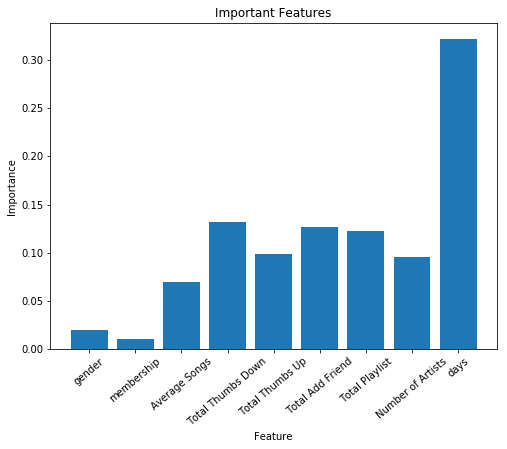

In [94]:
# Let's plot to find the importance in these features
plt.figure(figsize=[8,6])
plt.bar(x_values, importances_df, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Important Features')
plt.show();

We can see here that the most important feature was `days since registration`. `Gender` and `educational level` were the least important characteristics.

# Conclusion

We began the project with a small dataset of 128MB and 225 unique customers. We explored the dataset for useful features to predict the `churn` after loaded and cleaned our data. Moreover, we were able to build  out the most promising features. 
The features were then preprocessed and used with various ML algorithms. Because Random Forest performed the best, we tuned the model to an accuracy and F1 score of 0.75.

### Business Impact:

Sparkify can now use this information to focus on specific customers who are likely to churn and provide attractive promotions for them to stay, which could help Sparkify save their revenue while providing a good deal to the customer. 

We could focus into newer customers with a nice free trial of the premium service without those pesky ads because we discovered that they are more likely to churn. Sparkify could also work on a music recommendation system to recommend songs that users will like more and dislike less.



# Reference 

https://stackoverflow.com/questions/45946349/python-spark-cumulative-sum-by-group-using-dataframe
https://stackoverflow.com/questions/35247168/spark-sql-row-number-partitionby-sort-desc
https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/
https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
https://sparkbyexamples.com/pyspark/pyspark-window-functions/
https://stackoverflow.com/questions/21702342/creating-a-new-column-based-on-if-elif-else-condition     
https://stackoverflow.com/questions/46921465/extract-substring-from-text-in-a-pandas-dataframe-as-new-column     
https://developers.whatismybrowser.com/useragents/explore/layout_engine_name/trident/     
https://sparkbyexamples.com/pyspark/pyspark-when-otherwise/     
https://stackoverflow.com/questions/52943627/convert-a-pandas-dataframe-to-a-pyspark-dataframe     
https://stackoverflow.com/questions/29600673/how-to-delete-columns-in-pyspark-dataframe      
https://stackoverflow.com/questions/48738354/having-troubles-joining-3-dataframes-pyspark     
https://stackoverflow.com/questions/59886143/spark-dataframe-how-to-keep-only-latest-record-for-each-group-based-on-id-and    
https://stackoverflow.com/questions/46956026/how-to-convert-column-with-string-type-to-int-form-in-pyspark-data-frame    
https://medium.com/swlh/logistic-regression-with-pyspark-60295d41221     
https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa     
https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression     
https://stackoverflow.com/questions/60772315/how-to-evaluate-a-classifier-with-apache-spark-2-4-5-and-pyspark-python       
https://spark.apache.org/docs/2.2.0/ml-classification-regression.html    
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html      
https://stackoverflow.com/questions/32565829/simple-way-to-measure-cell-execution-time-in-ipython-notebook     
https://www.silect.is/blog/random-forest-models-in-spark-ml/     
https://stackoverflow.com/questions/75440/how-do-i-get-the-string-with-name-of-a-class
